<a href="https://colab.research.google.com/github/nurhabibrs/Capstone-Project-B21-CAP0463/blob/main/Anarki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anarki : First Layer Detection of Drug Abuse by Face Recognition Based on Mobile Apps**

### **Load Dataset**



In [ ]:
import numpy as np
import os
import tensorflow as tf
import pathlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [ ]:
# Check TF 2 Version
tf.__version__

'2.5.0'

In [ ]:
# Download Dataset 
dataset_url = "https://raw.githubusercontent.com/amaripujo/drug_abused/main/Update/drug_abused.tar.gz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='drug_abused', untar=True)
data_dir = pathlib.Path(data_dir)

42115072/42112378 [==============================] - 1s 0us/step


In [ ]:
# Mengecek Directori Dataset
print(data_dir)

/root/.keras/datasets/drug_abused


In [ ]:
# Direktori training gambar before dan after
train_before_dir = os.path.join(data_dir, 'before')
train_after_dir = os.path.join(data_dir, 'after')

In [ ]:
# Menampilkan daftar nama file masing-masing direktori
before_filenames = os.listdir(train_before_dir)
after_filenames = os.listdir(train_after_dir)

print(before_filenames[:10])
print(after_filenames[:10])

['25.5.PNG', '18.4.PNG', '19.0.PNG', '2.0.PNG', '17.0.PNG', '1.0.PNG', '17.1.PNG', '3.0.PNG', '2.3.PNG', '10.3.PNG']
['25.5.PNG', '18.4.PNG', '19.0.PNG', '2.0.PNG', '17.0.PNG', '1.0.PNG', '17.1.PNG', '3.0.PNG', '2.3.PNG', '10.3.PNG']


In [ ]:
# Melihat total gambar dalam direktori
print('Total Pelatihan gambar before :', len(os.listdir(train_before_dir)))
print('Total Pelatihan gambar after :', len(os.listdir(train_after_dir) ))

Total Pelatihan gambar before : 196
Total Pelatihan gambar after : 196


In [ ]:
%matplotlib inline

# Parameter dalam grafik yang akan menampilkan gambar 4x4
rows = 4
cols = 4

# Index untuk pengulangan gambar
indexes = 0 

#### **Visualisasi Data**

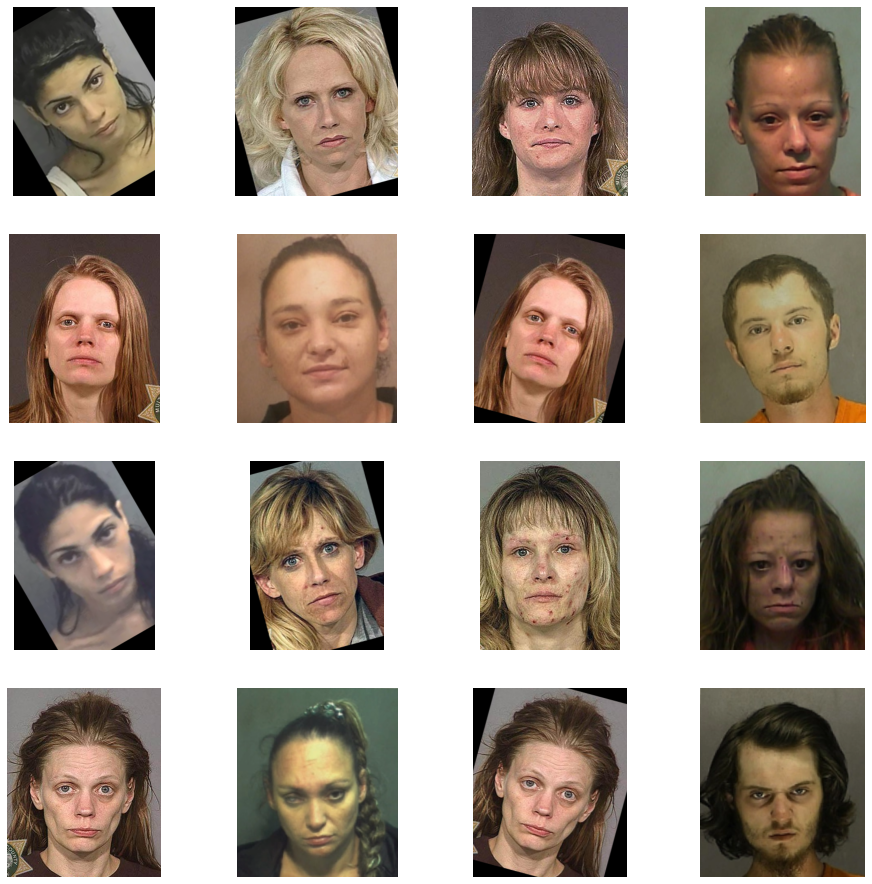

In [ ]:
# Visualisasi gambar sebanyak 4x4, 8 gambar atas untuk before, 8 gambar bawah untuk after
fig = plt.gcf()
fig.set_size_inches(cols*4, rows*4)

indexes+=8

before_picture = [os.path.join(train_before_dir, fname) for fname in before_filenames[indexes-8:indexes]]

after_picture = [os.path.join(train_after_dir, fname) for fname in after_filenames[indexes-8:indexes]]

for i, img_path in enumerate(before_picture+after_picture):
  vis = plt.subplot(rows, cols, i + 1)
  vis.axis('off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

### **Preprocessing Data**

In [ ]:
# Preprocessing data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

Found 392 files belonging to 2 classes.
Using 314 files for training.


In [ ]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

Found 392 files belonging to 2 classes.
Using 78 files for validation.


In [ ]:
classes = train_data.class_names
print(classes)

['after', 'before']


In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### **Standarisasi Data**

In [ ]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_data = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_data))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8819536


#### **Konfigurasi Performa Dataset**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

### **Build the Model**

In [ ]:
DESIRED_ACCURACY = 0.99

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>DESIRED_ACCURACY):
      print('\nReached 99% accuracy so cancelling training!')
      self.model.stop_training = True
    

callbacks = myCallback()

In [ ]:
# Data Augmentation untuk Menghindari Overfitting
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(180, 180,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [ ]:
# Membangun Model
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3,3), activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation ='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['acc'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_10 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 89, 89, 16)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 43, 43, 32)      

### **Training Data**

In [ ]:
history = model.fit(
      train_data, 
      epochs=100,
      validation_data=validation_data, 
      callbacks=[callbacks])

Epoch 1/100
10/10 [==============================] - 13s 1s/step - loss: 0.7895 - acc: 0.4554 - val_loss: 0.6901 - val_acc: 0.5000
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 0.6796 - acc: 0.5860 - val_loss: 0.6911 - val_acc: 0.5000
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 0.7224 - acc: 0.4554 - val_loss: 0.6904 - val_acc: 0.5769
Epoch 4/100
10/10 [==============================] - 12s 1s/step - loss: 0.6818 - acc: 0.5287 - val_loss: 0.6890 - val_acc: 0.5385
Epoch 5/100
10/10 [==============================] - 12s 1s/step - loss: 0.6774 - acc: 0.5828 - val_loss: 0.6873 - val_acc: 0.5769
Epoch 6/100
10/10 [==============================] - 12s 1s/step - loss: 0.6890 - acc: 0.5414 - val_loss: 0.6868 - val_acc: 0.5641
Epoch 7/100
10/10 [==============================] - 12s 1s/step - loss: 0.6742 - acc: 0.5860 - val_loss: 0.6863 - val_acc: 0.5128
Epoch 8/100
10/10 [==============================] - 12s 1s/step - loss: 0.6764 - a

### **Testing Data**

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(180, 180))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is adicted")
  else:
    print(fn + " is not adicted")

Saving WIN_20210601_09_03_55_Pro.jpg to WIN_20210601_09_03_55_Pro.jpg
[0.44584915]
WIN_20210601_09_03_55_Pro.jpg is not adicted


In [ ]:
#model.save("my_h5_model.h5")
joblib.dump(model, 'model.joblib')

NameError: ignored

### **Evaluating Accuracy and Loss Model**

Text(0.5, 1.0, 'Training and Validation Loss')

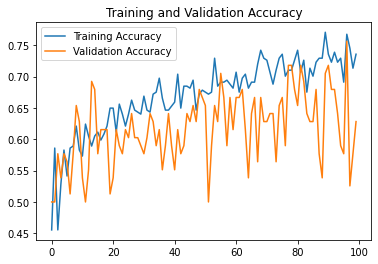

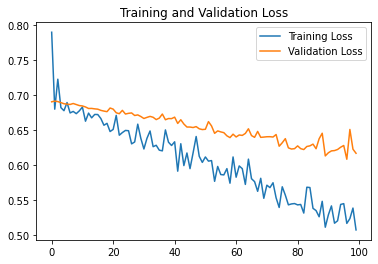

In [ ]:
# Visualisasi Hasil Accuracy dan Loss dalam Bentuk Grafik
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc))

# Grafik Akurasi Training dan Validation
plt.plot  (epochs, acc, label='Training Accuracy')
plt.plot  (epochs, val_acc, label= 'Validation Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.title ('Training and Validation Accuracy')

plt.figure()

# Grafik Loss Training dan Validation
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.legend(['Training Loss', 'Validation Loss'])
plt.title ('Training and Validation Loss')